# Predicting the Severity of a Traffic Collision

## Introduction
### Model Purpose
The purpose of this model is the predict the severity of a potential road accident (a binary measurement in this case). This is to attempt to avoid the possibility of being stuck in traffic induced by a severe accident (denoted as 2, whereas a less severe accident is denoted as 1). The severity of an accident will be predicted based on the road and light conditions at a given point in time. 

### Primary Audience / Stakeholders

This type of model is useful for anyone seeking to plan a trip and wish to avoid being stuck in traffic due to accidents. Perhaps it is especially useful for those who value avoiding wasting their time in traffic, and have the ability to plan their travelling. E.g., delivery drivers may not benefit as much for this model as, for instance, people travelling for leisure/vacation, as the former are often on a schedule outside of their control and may therefore be forced to travel irrespective of what the model suggests. However, the model can be used to plan deliveries (and the like) more carefully, and reduction of leuisarly drivers during more accident prone times will still benefit those with less choice.

## Data

The data used in this work is from the Seattle Department of Transportation (SDOT). It contains information about all of the traffic collisions in Seattle from 2004 until present day (2020). The data was provided by the Seattle Police Department (SPD) and recorded by Traffic Records. The data is recorded in [Data-Collisions.csv](https://github.com/jstr0em/coursera-capstone/blob/master/Data-Collisions.csv) with metadata in [Metadata.pdf](https://github.com/jstr0em/coursera-capstone/blob/master/Metadata.pdf). Both of these files are available in the same [GitHub](https://github.com/jstr0em/coursera-capstone) repository as this work.

## Methodology

### Data Exploration

First we need to examine our dataset to gain an understanding of the data. The purpose of which is to select relevant features and choosing an appropriate model. However, we already know that we are interested in predicting the severity of a collision, and this is given by the SEVERITYCODE value associated with each collision. 

From reading the metadata, there are potentially 5 different values for SEVERITYCODE:

| SEVERITYCODE | Meaning | 
| --- | --- |
| 3 | Fatality |
| 2b | Serious injury |
| 2 | Injury |
| 1 | Property damange |
| 0 | Unknown |

With that said, let's scan the data. 

In [2]:
import pandas as pd

# loads data
data = pd.read_csv('Data-Collisions.csv')
data.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


Here we can see that the data contains a significant number of potentially relevant features, and we will need to select which ones we wish to exclude/keep (more on that below).

In [3]:
data['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

#### Collision Map

For fun, let's visualize some of the collisions!

In [21]:
import folium
import numpy as np

# sets up the map centered in Seattle
m = folium.Map(
    location=[47.607182, -122.334487], # NW coordinates of Seattle
    zoom_start=12,
    ) 

# picks 20 random collisions
random_collisions = data[['X','Y','SEVERITYCODE']].dropna().sample(20,random_state=40)

# property damages are in orange and injuries in red
colors = {1: 'orange', 2: 'red'}

# places the markers
for i, collision in random_collisions.iterrows():
    folium.Marker(
        location=[collision['Y'], collision['X']], 
        icon=folium.Icon(icon='circle', color=colors[collision['SEVERITYCODE']]),
    ).add_to(m)
m.save('figures/collision_map.html')
m

We also see that there are only two SEVERITYCODE values of the five possible. We also observe that a value of 1 (property damage) is much more common than 2 (injury), thus the data is somewhat unbalanced.

#### Excluding Features

On to examining which features there are in detail and exluding irrelevant ones.

In [5]:
# lists all the features in the dataset and some information about them
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

As we can see, there are a lot of different features to choose from. There are too many in fact and we need to investigate which of these are relevant for solving the outlined problem. This will be achieved by reading each feature description in Metadata.pdf.

##### Irrelevant Features
To start, we will exclude features that are obviously irrelevant, such as features containing various identification numbers. We also remove dates/timestamps as an accident is obviously not dependent on a particular day. 

We remove:
* OBJECTID
* INCKEY 
* COLDETKEY
* REPORTNO
* STATUS
* INTKEY
* EXCEPTRSNCODE
* EXCEPTRSNDESC
* SEVERITYCODE.1 (Duplicate)
* SEVERITYDESC
* INCDATE
* INCDTTM
* SDOTCOLNUM

Additionally, there are features that detail how many vehicles/persons were part of a particular accident. Naturally, the more people/vehicles, the more severe an accident is likely to be. Using this data for predictive purposes is not practical, so this is likewise excluded

We remove:
* PEDCOUNT (number of pedestrians)
* PEDCYLCOUNT (number of pedestrians and cyclists)
* PERSONCOUNT (number of persons)
* VEHCOUNT (number of vehicles)


In [6]:
# list for storing which features to exclude
features_to_exclude = ['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'INCDATE', 'INCDTTM', 'SDOTCOLNUM', 'PEDCOUNT', 'PEDCYLCOUNT', 'PERSONCOUNT', 'VEHCOUNT']

##### A Priori / Illegal Features

We also exclude features which obviously increase the risk of a traffic incident (and which are illegal) such as driving under the influence, not paying attention, driving without adequate rest, or speeding. While these obviously are correlated with the risk and severity of traffic accidents, they present no additional information to a prudent driver seeking to avoid accidents.

We remove:
* SPEEDING (speeding driver)
* UNDERINFL (drunk driver)
* INATTENTIONIND (inattentive driver)
* PEDROWNOTGRNT (not giving pedestrian right of way - illegal driving)

In [7]:
# appending to the list
features_to_exclude += ['SPEEDING', 'UNDERINFL', 'INATTENTIONIND', 'PEDROWNOTGRNT']

##### Too Detailed Features

There are some features that contain a bit too much detailed information about the crashes, and cannot readily be used to avoid accidents, but may be useful for understanding them. However, the latter is more relevant to car manufacturers to design safer cars or to road engineer for designing safer roads; these insights are not relevant for this application. Furthermore, many of the features contain too detailed information about accidents and cannot readily be generalized.

The following features corresponds to these types of information, and thus are excluded:
* ST_COLCODE & ST_COLDESC (details of which direction a car was traveling in before an accident)
* SDOT_COLCODE & SDOT_COLDESC (details of the specific accident)
* SEGLANEKEY (details of which lane segment an accident occured; not practical to avoid lane changing)
* CROSSWALKKEY (which crosswalk an accident occured in)
* HITPARKEDCAR (if a parked car was hit)
* COLLISIONTYPE (also contains information of what the driver was doing while the accident occured)
* JUNCTIONTYPE (which junction types an accident occured in; not practical to avoid any of these)
* ADDRTYPE (similar to JUNCTIONTYPE)

One feature that contains significant information about traffic accidents that would be useful to use is the location of where an accident was recorded X & Y. However, it is beyond the scope of this model to use these, but would be neat to incorporate into a model where a detailed travel path is given as an input (e.g. like in Google Maps).

We also exclude:
* X & Y (contains specific coordinates; might relevant but too difficult to use in this model)
* LOCATION (detailed description of the location)

In [8]:
# appending to the list
features_to_exclude += ['ST_COLCODE', 'ST_COLDESC', 'SDOT_COLCODE', 'SDOT_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'ADDRTYPE', 'X', 'Y', 'LOCATION']

##### Surviving Features

In [9]:
# target feature 
target = 'SEVERITYCODE'

# all the features in the dataset
all_features = list(data)

# creates list of features we've decided to keep (i.e. we remove the feature we want to exclude and the target variable from all the columns in the dataset)

features = list(set(all_features).difference(features_to_exclude+[target]))

# new dataframae only containing the target and feature variables
df = data[[target]+features]

# removing any nans
df.dropna(inplace=True) 

After removing all the discussed features we are left with only these three:
* WEATHER
* LIGHTCOND
* ROADCOND

These are great for predictive purposes as they are easy to use generate for a prediction; you just need to check the weather. They are also not particularly specific to any specific location in the Seattle area, or indeed the Seattle area itself, thus it can more readily be exted to other examples. 

Each of these features contain the following values:
* ROADCOND: Dry, Ice, Oil, Other, Sand/Mud/Dirt, Snow/Slush, Standing Water, Unknown, Wet
* LIGHTCOND: Dark - No Street Lights, Dark - Street Lights Off, Dark - Street Lights On, Dark - Unknown Lighting, Dawn, Daylight, Dusk, Other, Unknown
* WEATHER: Blowing, Sand/Dirt, Clear, Fog/Smog/Smoke, Other, Overcast, Partly Cloudy, Raining, Severe Crosswind, Sleet/Hail/Freezing, Rain, Snowing, Unknown

In particular weather is important to include here, as the combination of one poor weather phenomena together with otherwise good road conditions may still make for less safe driving - i.e. dry roads by with severe crosswinds.


In [10]:
df.groupby(target)[features[0]].value_counts().unstack()


LIGHTCOND,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,Unknown
SEVERITYCODE,,,,,,,,,
1,1201,876,33989,7,1678,77549,3951,183,12851
2,334,316,14451,4,824,38528,1938,52,605


In [11]:
df.groupby(target)[features[1]].value_counts().unstack()

WEATHER,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,Overcast,Partly Cloudy,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown
SEVERITYCODE,,,,,,,,,,,
1,40,75200,382,708,18942,2,21949,18,85,732,14227
2,15,35808,187,116,8739,3,11168,7,28,169,812


In [12]:
df.groupby(target)[features[2]].value_counts().unstack()

ROADCOND,Dry,Ice,Oil,Other,Sand/Mud/Dirt,Snow/Slush,Standing Water,Unknown,Wet
SEVERITYCODE,,,,,,,,,
1,84296,933,40,88,51,833,85,14284,31675
2,40004,273,24,43,23,166,30,747,15742


### Data Preprocessing


We notice that there are probably more feature values in our three features than needed. Specifically, we will do the following operations:
* Remove all 'Unknown' and 'Other' entries from all features. 
* Merge all 'Dark ...' into just 'Dark' in LIGHTCOND. The extra data in what sort of (or lack of) artifical lighting is available is just not very practical in this application. 

In [13]:

# removing all unknown and others 
for feature in features:
    df.drop(df.loc[df[feature]=='Unknown'].index, inplace=True)
    df.drop(df.loc[df[feature]=='Other'].index, inplace=True)
"""
# merging all dark
df['LIGHTCOND'].replace(['Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Street Lights On', 'Dark - Unknown Lighting'], 'Dark', inplace=True)

# checking if everything is in order
df.groupby(target)['LIGHTCOND'].value_counts().unstack()
"""

"\n# merging all dark\ndf['LIGHTCOND'].replace(['Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Street Lights On', 'Dark - Unknown Lighting'], 'Dark', inplace=True)\n\n# checking if everything is in order\ndf.groupby(target)['LIGHTCOND'].value_counts().unstack()\n"

Our target variable as well as our features are all categorical, thus we will need to convert them into some kind of numerical value. Here we can use a label encoding (converting strings to intergers, but keeping columns) or one-hot encoding (expanding number of columns and each only contains a binary value). We pick one-hot encoding, to avoid issues with our models assuming the numeric values from label encoding actually have any significance.

In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(df[features])

X = enc.transform(df[features])
Y = df[target]

Recall also that we determined earlier that our dataset was unblanced, and heavily biased towards property damage over injury (SEVERITYCODE 1 and 2 respespectively). While this is great in reality, it may present problems for our model as we may seriously underpredict the likelihood of a collision resulting in an injury. To attempty to rectify this, we will undersample the training set and compare its performance to the unblanced dataset. 

In [15]:
# splitting the data into train/test sets
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

nm = NearMiss()
X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)

As we can see, the resampled training set is perfectly balanced. 

In [17]:
Y_train_res.value_counts()

2    44591
1    44591
Name: SEVERITYCODE, dtype: int64

### Data Modeling / Analysis

Given our labeled data, it is most appropriate to use some classification algorithm. There are many options available, and we will use a Linear SVC and a Logistic Regression algorithm, to have some comparisons to make.

In [18]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# SVC training 

# unbalanced training data
svc = LinearSVC()
svc.fit(X_train, Y_train)

# balanced training data
svc_res = LinearSVC()
svc_res.fit(X_train_res, Y_train_res)

# log reg training 

# unbalanced training data
lr = LogisticRegression()
lr.fit(X_train, Y_train)

# balanced training data
lr_res = LogisticRegression()
lr_res.fit(X_train_res, Y_train_res)

# SVC prediction
Y_svc = svc.predict(X_test)
Y_svc_res = svc_res.predict(X_test)

# log reg prediction
Y_lr = lr.predict(X_test)
Y_lr_res = lr_res.predict(X_test)

## Results and Discussion

To analyze the performance of each model, we produce a confusion matrix, and calculate the recall, precision, and F1 score of each model.

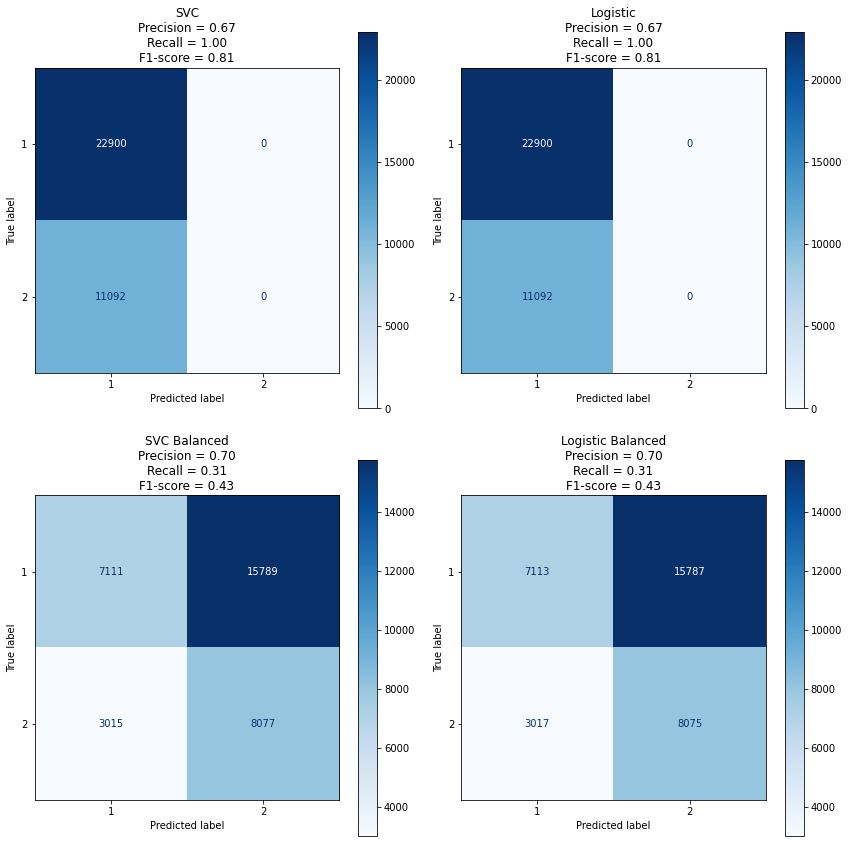

In [19]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
import matplotlib.pyplot as plt 

# sets up the figure
fig, axes = plt.subplots(2,2, figsize=(12,12))

# the estimators, their names, and predicted values to be used in the analysis
titles = ['SVC', 'Logistic', 'SVC Balanced', 'Logistic Balanced']
estimators = [svc, lr, svc_res, lr_res]
predicted_values = [Y_svc, Y_lr, Y_svc_res, Y_lr_res]

# plots the confusion matrix for each model and calculates some scores
for clf, ax, title, Y_pred in zip(estimators, axes.flatten(), titles, predicted_values):
    # confusion matrix
    plot_confusion_matrix(clf, X_test, Y_test, ax=ax, cmap='Blues')

    # adds titles with a description of the model and its associated scores
    ax.set(
        title=title+'\nPrecision = %1.2f\nRecall = %1.2f\nF1-score = %1.2f' %  (precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred), f1_score(Y_test, Y_pred)),
    )

fig.tight_layout()

Look at the two models with their two respectively unbalanced and balanced datasets, we see that there is quite a lot going on. One thing that immediately stands out is that for the given unbalanced/balanced dataset, the models perform more or less equally in terms of their predictions and associated scores. However, we see that the models perform drastically differently depending on if the unbalanced or balanced dataset was used for training. 

When the unbalanced dataset was used, we see that the models never predict that a SEVERITYCODE = 2 collision occurs, i.e. all collisions will only result in property damage (and thus less severe traffic jams). Despite this inability to predict more serious collisions, the accuracy scores are quite good. This is a problem for our applications however, as we will always miss any serious collisions and thus defeat the purpose of this model - to avoid being stuck in traffic. 

In this case, it is better to be much more conservative in our predictions, i.e. it is better to overpredict the probability of a SEVERITYCODE = 2 collision. This is of course assuming that a more serious collision will result in much longer traffic delays (which seems quite reasonable). 

With the balanced dataset used for training, we see that our overall scores decrease significantly, and in fact are not that good. However, like discussed, we do predict far more serious collisions, giving these models a more conservative estimation of the risk of a collision. This is preferable for our purposes; **despite the poorer accuracy metrics, the models trained using the balanced datasets are preferable**.

Let's extract some more information from these "balanced" models, and see which features are most weighted 


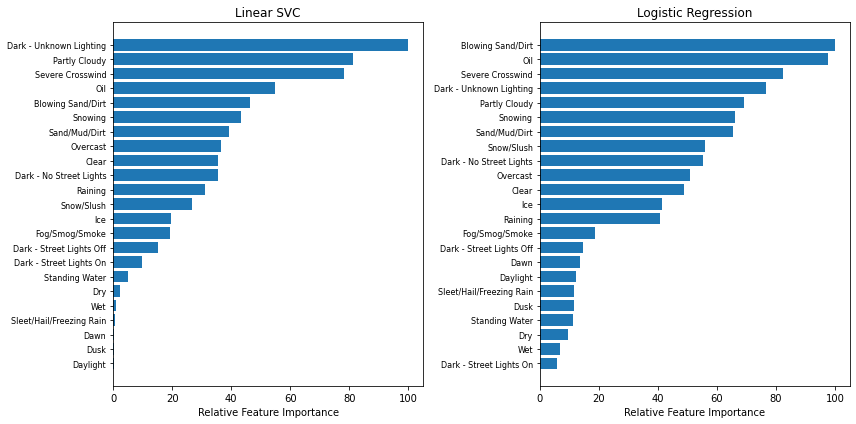

In [20]:
def plot_relative_feature_importance(ax, clf):
    # calculates the relative importance of each feature 
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    # sorts the features by importance
    sorted_idx = np.argsort(feature_importance)

    # positions of the bars
    pos = np.arange(sorted_idx.shape[0]) + .5

    # plots the relative importance as bars
    ax.barh(pos, feature_importance[sorted_idx], align='center')

    # add ticks and labels on the axes
    ax.set_yticks(pos)
    ax.set_yticklabels(labels[sorted_idx], fontsize=8)
    ax.set_xlabel('Relative Feature Importance')

    return ax

# gets the feature names used in the models and cleans them up a bit 
X_train_res.columns = enc.get_feature_names()
labels = np.array([val[3:] for val in X_train_res.columns])


# plots the figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1 = plot_relative_feature_importance(ax1, svc_res)
ax2 = plot_relative_feature_importance(ax2, lr_res)

ax1.set_title('Linear SVC')
ax2.set_title('Logistic Regression')

fig.tight_layout()


### Relative Feature Importance 

From the figures above, we can see which features with the largest importance for predictions of the two models. As we saw before, the two models performed almost identically in their predictions and their accuracy scores. Interestignly these similarities do not extend to feature importance, and we can see that different features are deemed most important for predictions. Determining which one is more "right" is difficult to access without additional information, but the results are reasonably similar; more rare and extreme phenomena are typically more important - which makes intuitive sense. 

### Potential Limitations of Model

While the data used to create the model is based on traffic accident data in Seattle, it is likely that the model is generalizable to situations outside of Seattle as well. However, this predictive ability likely decreases as the predicted area becomes more different from Seattle. For instance, Seattle is located in the Pacific Northwest of the United States, and the model will likely perform best for areas that has similar driving laws/cultures and climate as Seattle does. Thus, this model is most useful to stakeholders travelling through areas of this type. 
 
Another limitation is that there are only two type of collisions in the dataset - property damage and injuries. This is obviously a problem as it is impossible to predict other types of collision outcomes. 

## Conclusion

In this study, we have designed a model that predicts the severity of a road collision based on the weather, road conditions, and lighting conditions. The purpose of this is to allow the user to plan their travels in such a way to reduce the chance of more severe accidents occuring, and thereby reducing their time in traffic caused by these accidents. Due to limitations in the dataset, it is only possible to predict one out of two classes of collisions, either ones resulting in only property damage (less severe accidents) or those resulting in injuries (more severe accidents). Two classification models were used in this work - Linear SVC and Logistic Regression, and according to the measured metrics, both of these performed equally well for this application. 

The dataset was significantly unbalanced, and accidents resulting in property damage were much more common than those resulting in injuries. This necessitated the resampling of the dataset to contain equal number of types of collisions, otherwise a heavy bias for less severe accidents would be introduced, and thus eliminating the utility of this model. The resampling had the effect of instead creating a bias towards more significant accidents. This was deemed preferable, as it is better to be overly conservative in this application. 

The modeling also revealed which conditions are most important in our models. While the exact feature importance ranking within each model differed somewhat, both agreed that more extreme conditions are relatively more important, e.g. driving in the dark, during snow, or heavy wind. These results are not that surprising, but is an important "sanity check" to see if our model predictions make sense. 